In [46]:
import gym as gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Categorical

class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=64, epsilon=0.2, epoch_n=20, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, action_dim), nn.Softmax(dim=-1))

        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.pi_model(state)
        dist = Categorical(probs)
        action = dist.sample()

        return action.item(), dist.log_prob(action)

    def fit(self, states, actions, rewards, dones):
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        actions = actions.long()

        probs = self.pi_model(states)
        dist = Categorical(probs)
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = b_returns.detach() - self.v_model(b_states)

                b_probs = self.pi_model(b_states)
                b_dist = Categorical(b_probs)
                b_new_log_probs = b_dist.log_prob(b_actions)


                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon, 1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                self.pi_optimizer.zero_grad()
                pi_loss.backward()
                self.pi_optimizer.step()

                v_loss = torch.mean((b_advantage ** 2).squeeze())

                self.v_optimizer.zero_grad()
                v_loss.backward()
                self.v_optimizer.step()

/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Mean Reward: -200.0
Episode 2, Mean Reward: -200.0
Episode 3, Mean Reward: -200.0
Episode 4, Mean Reward: -199.08
Episode 5, Mean Reward: -198.42
Episode 6, Mean Reward: -195.96
Episode 7, Mean Reward: -191.46
Episode 8, Mean Reward: -188.88
Episode 9, Mean Reward: -184.28
Episode 10, Mean Reward: -181.6
Episode 11, Mean Reward: -176.22
Episode 12, Mean Reward: -171.5
Episode 13, Mean Reward: -172.02
Episode 14, Mean Reward: -173.58
Episode 15, Mean Reward: -175.1
Episode 16, Mean Reward: -156.24
Episode 17, Mean Reward: -160.04
Episode 18, Mean Reward: -164.22
Episode 19, Mean Reward: -156.82
Episode 20, Mean Reward: -151.14
Episode 21, Mean Reward: -146.22
Episode 22, Mean Reward: -134.7
Episode 23, Mean Reward: -135.84
Episode 24, Mean Reward: -132.78
Episode 25, Mean Reward: -133.5
Episode 26, Mean Reward: -132.52
Episode 27, Mean Reward: -131.96
Episode 28, Mean Reward: -117.88
Episode 29, Mean Reward: -117.32
Episode 30, Mean Reward: -115.4
Episode 31, Mean Reward: -11

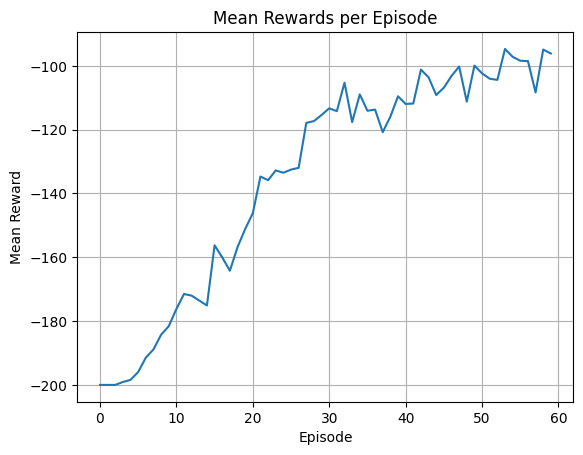

In [47]:
import gym
import numpy as np
import matplotlib.pyplot as plt


env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = PPO(state_dim, action_dim)

episode_n = 60
trajectory_n = 50

mean_rewards = []

for episode in range(episode_n):

    states, actions, rewards, train_rewards, dones = [], [], [], [], []
    total_reward = 0

    for _ in range(trajectory_n):
        state = env.reset()
        traj_rew = 0
        for t in range(200):
            states.append(state)

            action, _ = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            #if reward == 0:
                #train_reward = 100
               # train_rewards.append(train_reward)
           # else:
               # train_rewards.append(reward)
            rewards.append(reward)

            dones.append(done)
            traj_rew += reward
            total_reward += reward
            if done:
                break
    mean_reward = total_reward / trajectory_n
    mean_rewards.append(mean_reward)
    print(f"Episode {episode + 1}, Mean Reward: {mean_reward}")

    agent.fit(states, actions, rewards, dones)

plt.plot(mean_rewards)
plt.title('Mean Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.grid()
plt.show()


Episode 1, Mean Reward: -99.38
Episode 2, Mean Reward: -94.12
Episode 3, Mean Reward: -100.94
Episode 4, Mean Reward: -100.46
Episode 5, Mean Reward: -96.74
Episode 6, Mean Reward: -92.14
Episode 7, Mean Reward: -95.52
Episode 8, Mean Reward: -95.98
Episode 9, Mean Reward: -92.1
Episode 10, Mean Reward: -96.1
Episode 11, Mean Reward: -100.4
Episode 12, Mean Reward: -96.96
Episode 13, Mean Reward: -93.8
Episode 14, Mean Reward: -97.62
Episode 15, Mean Reward: -93.84
Episode 16, Mean Reward: -96.9
Episode 17, Mean Reward: -91.68
Episode 18, Mean Reward: -94.92
Episode 19, Mean Reward: -87.92
Episode 20, Mean Reward: -93.36


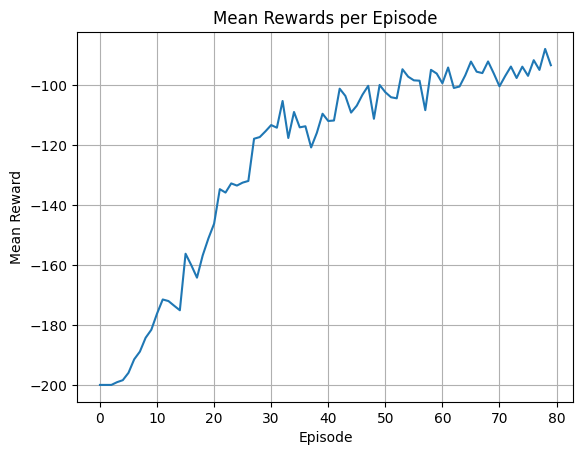

In [48]:
episode_n=20
for episode in range(episode_n):

    states, actions, rewards, train_rewards, dones = [], [], [], [], []
    total_reward = 0

    for _ in range(trajectory_n):
        state = env.reset()
        traj_rew = 0
        for t in range(200):
            states.append(state)

            action, _ = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            #if reward == 0:
            #train_reward = 100
            # train_rewards.append(train_reward)
            # else:
            # train_rewards.append(reward)
            rewards.append(reward)

            dones.append(done)
            traj_rew += reward
            total_reward += reward
            if done:
                break
    mean_reward = total_reward / trajectory_n
    mean_rewards.append(mean_reward)
    print(f"Episode {episode + 1}, Mean Reward: {mean_reward}")

    agent.fit(states, actions, rewards, dones)

plt.plot(mean_rewards)
plt.title('Mean Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.grid()
plt.show()


Episode 1, Mean Reward: -89.02
Episode 2, Mean Reward: -86.8
Episode 3, Mean Reward: -95.36
Episode 4, Mean Reward: -101.48
Episode 5, Mean Reward: -89.62
Episode 6, Mean Reward: -96.56
Episode 7, Mean Reward: -90.78
Episode 8, Mean Reward: -91.86
Episode 9, Mean Reward: -89.64
Episode 10, Mean Reward: -88.82
Episode 11, Mean Reward: -86.0
Episode 12, Mean Reward: -91.34
Episode 13, Mean Reward: -92.3
Episode 14, Mean Reward: -90.88
Episode 15, Mean Reward: -94.46
Episode 16, Mean Reward: -91.94
Episode 17, Mean Reward: -84.82
Episode 18, Mean Reward: -86.62
Episode 19, Mean Reward: -85.78
Episode 20, Mean Reward: -90.1


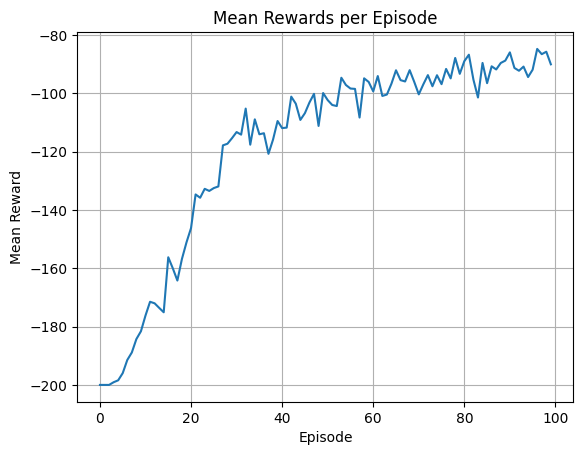

In [49]:
episode_n=20
for episode in range(episode_n):

    states, actions, rewards, train_rewards, dones = [], [], [], [], []
    total_reward = 0

    for _ in range(trajectory_n):
        state = env.reset()
        traj_rew = 0
        for t in range(200):
            states.append(state)

            action, _ = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            #if reward == 0:
            #train_reward = 100
            # train_rewards.append(train_reward)
            # else:
            # train_rewards.append(reward)
            rewards.append(reward)

            dones.append(done)
            traj_rew += reward
            total_reward += reward
            if done:
                break
    mean_reward = total_reward / trajectory_n
    mean_rewards.append(mean_reward)
    print(f"Episode {episode + 1}, Mean Reward: {mean_reward}")

    agent.fit(states, actions, rewards, dones)

plt.plot(mean_rewards)
plt.title('Mean Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.grid()
plt.show()


Episode 1, Mean Reward: -95.42
Episode 2, Mean Reward: -88.58
Episode 3, Mean Reward: -94.66
Episode 4, Mean Reward: -90.08
Episode 5, Mean Reward: -85.94
Episode 6, Mean Reward: -88.0
Episode 7, Mean Reward: -90.38
Episode 8, Mean Reward: -85.16
Episode 9, Mean Reward: -85.68
Episode 10, Mean Reward: -89.12
Episode 11, Mean Reward: -85.32
Episode 12, Mean Reward: -88.38
Episode 13, Mean Reward: -93.22
Episode 14, Mean Reward: -84.08
Episode 15, Mean Reward: -90.82
Episode 16, Mean Reward: -86.76
Episode 17, Mean Reward: -85.12
Episode 18, Mean Reward: -83.98
Episode 19, Mean Reward: -90.78
Episode 20, Mean Reward: -84.7


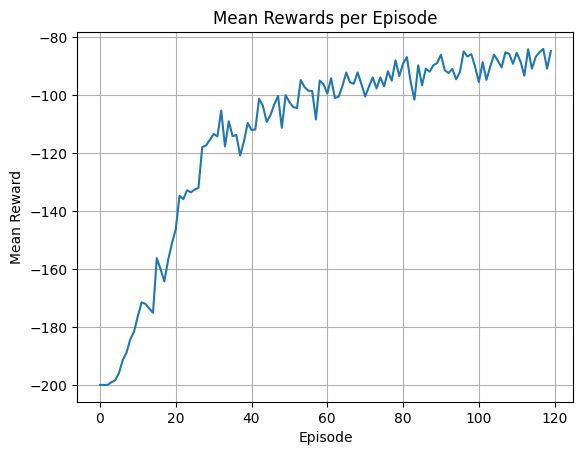

In [50]:
episode_n=20
for episode in range(episode_n):

    states, actions, rewards, train_rewards, dones = [], [], [], [], []
    total_reward = 0

    for _ in range(trajectory_n):
        state = env.reset()
        traj_rew = 0
        for t in range(200):
            states.append(state)

            action, _ = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            #if reward == 0:
            #train_reward = 100
            # train_rewards.append(train_reward)
            # else:
            # train_rewards.append(reward)
            rewards.append(reward)

            dones.append(done)
            traj_rew += reward
            total_reward += reward
            if done:
                break
    mean_reward = total_reward / trajectory_n
    mean_rewards.append(mean_reward)
    print(f"Episode {episode + 1}, Mean Reward: {mean_reward}")

    agent.fit(states, actions, rewards, dones)

plt.plot(mean_rewards)
plt.title('Mean Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.grid()
plt.show()

